### AirBNB COVID-19 analysis

# What was the impact of Covid-19 to Airbnb bookings in Seattle?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
import gzip
import shutil
from pathlib import Path

In [2]:

# We want to have a deeper look at the adjusted_price for the upcoming 30 days of not available listings as stated in the calendar.

# Ignore the day when the data was scraped. Start with the second day
offset_days = 1

# data to load from gzip files in the data directory. Every "scraping date" is the name of the subfolder where listings.gz and calendar.gz are located
dates = ['20190117', '20190209', '20190311', '20190415', '20190518', '20190613', '20190714', '20190818', '20190922', '20191018', 
        '20191121', '20191219', '20200115', '20200222', '20200317', '20200423', '20200521', '20200617']
#dates = ['20190415', '20200423'] # Compare only april 2019/2020

listings = pd.DataFrame()
calendar = pd.DataFrame()

for date in dates:
    print('Reading files for {}'.format(date))
    with gzip.open('./data/{}/listings.csv.gz'.format(date),"rb") as f:
        listings_part = pd.read_csv(f)

    listings_part['date'] = pd.to_datetime(date)

    # Drop listings with missing data; no imputing needed because data quantity and quality is sufficient
    listings_part.dropna(subset=['price', 'bathrooms','bedrooms','beds', 'cleaning_fee'], inplace=True)

    # Some conversions / cleanup
    listings_part['price'] = listings_part['price'].str.replace('[$, ]', '').astype('float')
    listings_part['cleaning_fee'] = listings_part['cleaning_fee'].str.replace('[$, ]', '').astype('float')
    listings=listings.append(listings_part, ignore_index=True)

    # drop unreasonable listings >2000$ per day
    listings_part.drop(listings_part[(listings_part.price > 2000 ) | (listings_part.price < 10)].index, inplace=True) 

    # Analyse one day after the scrape date! The first day may be no longer available, because it's too late.
    start_date = pd.Timestamp(date) + pd.Timedelta(days=offset_days)
    end_date = start_date + pd.Timedelta(days=30)

    with gzip.open('./data/{}/calendar.csv.gz'.format(date),"rb") as f:
        calendar_part = pd.read_csv(f)

    # drop of unused data because of memory consumption
    calendar_part.drop(columns = ['minimum_nights', 'maximum_nights'], inplace=True)

    # We only want to look to 30 days after the scrape date. And we are only interested in days which are no longer available. Drop the rest first to save memory!
    # Droping this first (incl. date conversation) is 3x faster then doing it afterwards. 
    calendar_part['date'] = pd.to_datetime(calendar_part['date'])
    calendar_part.drop(calendar_part[(calendar_part.date < start_date ) | (calendar_part.date > end_date) | (calendar_part.available == 't')].index, inplace=True)

    # Some conversations / cleanup 
    calendar_part['price'] = calendar_part['price'].str.replace('[$, ]', '').astype('float')
    calendar_part['adjusted_price'] = calendar_part['adjusted_price'].str.replace('[$, ]', '').astype('float')

    # drop unreasonable calendar entries >2000$ per day
    calendar_part.drop(calendar_part[(calendar_part.price > 2000 ) | (calendar_part.price < 10)].index, inplace=True)  # drop unreasonable listings >2000$ per day
    calendar_part.drop(calendar_part[(calendar_part.adjusted_price > 2000 ) | (calendar_part.adjusted_price < 10)].index, inplace=True)  # drop unreasonable listings >2000$ or <10$ per day

    calendar=calendar.append(calendar_part, ignore_index=True)

display(listings.head())

display(calendar.head())


Reading files for 20190117
Reading files for 20190209
Reading files for 20190311
Reading files for 20190415
Reading files for 20190518
Reading files for 20190613
Reading files for 20190714
Reading files for 20190818
Reading files for 20190922
Reading files for 20191018
Reading files for 20191121
Reading files for 20191219
Reading files for 20200115
Reading files for 20200222
Reading files for 20200317
Reading files for 20200423
Reading files for 20200521
Reading files for 20200617


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,date
0,2318,https://www.airbnb.com/rooms/2318,20190117134415,2019-01-17,"Casa Madrona - Urban Oasis, 1 block from the P...","Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, (Phone number h...",none,Madrona is a hidden gem of a neighborhood. It ...,...,f,strict_14_with_grace_period,f,f,3,2,1,0,0.17,2019-01-17
1,3335,https://www.airbnb.com/rooms/3335,20190117134415,2019-01-17,Sweet Seattle Urban Homestead 2 Bdr,Welcome! If you stay here you will be living i...,Welcome! Come enjoy your time in Seattle at a...,Welcome! If you stay here you will be living i...,none,This is a very diverse neighborhood with a var...,...,f,strict_14_with_grace_period,f,f,1,1,0,0,0.03,2019-01-17
2,4291,https://www.airbnb.com/rooms/4291,20190117134415,2019-01-17,Sunrise in Seattle Master Suite,This property is located in the lovely Maple L...,"Located in Seattle, this is a spacious, clean ...",This property is located in the lovely Maple L...,none,NaN,...,f,moderate,f,f,5,1,4,0,0.93,2019-01-17
3,5682,https://www.airbnb.com/rooms/5682,20190117134415,2019-01-17,"Cozy Studio, min. to downtown -WiFi",The Cozy Studio is a perfect launchpad for you...,"Hello fellow travelers, Save some money and ha...",The Cozy Studio is a perfect launchpad for you...,none,NaN,...,f,strict_14_with_grace_period,f,t,1,1,0,0,4.30,2019-01-17
4,6606,https://www.airbnb.com/rooms/6606,20190117134415,2019-01-17,"Fab, private seattle urban cottage!",NaN,"Soo centrally located, this is a little house ...","Soo centrally located, this is a little house ...",none,"A peaceful yet highly accessible neighborhood,...",...,f,strict_14_with_grace_period,f,f,3,3,0,0,1.16,2019-01-17


,listing_id,date,available,price,adjusted_price
0,2318,2019-01-18,f,250.0,250.0
1,208356,2019-01-18,f,89.0,89.0
2,208356,2019-01-19,f,89.0,89.0
3,208356,2019-01-20,f,89.0,89.0
4,208356,2019-01-21,f,89.0,89.0


In [3]:
# Calculate mean adjusted_prices30 from calendar entries of 30 days after scraping date (=cal_adjusted_price30).

listings['cal_adjusted_price30'] = np.nan

for date in listings['date'].unique():
    print('Processing {}'.format(date))
    start_date = date + pd.Timedelta(days=offset_days)
    end_date = start_date + pd.Timedelta(days=30)

    listings_date = listings[listings['date'] == date]
    calendar_date = calendar[(calendar['date'] >= start_date ) & (calendar['date'] <= end_date)]

    for index, row in listings_date.iterrows():
        id_col = row['id']
        listings.at[index, 'cal_adjusted_price30'] = calendar_date[(calendar_date['listing_id'] == id_col)]['adjusted_price'].mean()

# Drop all listings without calendar entries
listings.dropna(subset=['cal_adjusted_price30'], inplace=True)

listings[['id', 'price', 'cal_adjusted_price30']]

Processing 2019-01-17T00:00:00.000000000
Processing 2019-02-09T00:00:00.000000000
Processing 2019-03-11T00:00:00.000000000
Processing 2019-04-15T00:00:00.000000000
Processing 2019-05-18T00:00:00.000000000
Processing 2019-06-13T00:00:00.000000000
Processing 2019-07-14T00:00:00.000000000
Processing 2019-08-18T00:00:00.000000000
Processing 2019-09-22T00:00:00.000000000
Processing 2019-10-18T00:00:00.000000000
Processing 2019-11-21T00:00:00.000000000
Processing 2019-12-19T00:00:00.000000000
Processing 2020-01-15T00:00:00.000000000
Processing 2020-02-22T00:00:00.000000000
Processing 2020-03-17T00:00:00.000000000
Processing 2020-04-23T00:00:00.000000000
Processing 2020-05-21T00:00:00.000000000
Processing 2020-06-17T00:00:00.000000000


,id,price,cal_adjusted_price30
0,2318,296.0,250.000000
3,5682,48.0,49.282051
4,6606,90.0,90.000000
5,9419,65.0,67.500000
6,9460,79.0,100.937500
...,...,...,...
135677,43802203,152.0,116.555556
135678,43804294,86.0,65.400000
135680,43807087,119.0,124.714286
135681,43807576,299.0,234.200000


In [4]:
def analyze_listings(df, dates_filter = None, plothist = False):
    '''
    INPUT
    df - dataframe with airbnb listings data
    dates_filter - pandas dataframe, response variable
    plothist - boolean, default False, True to plot results

    OUTPUT
    result - dataframe with analysis per date

    Analyses the airbnb listings per date regarding number of listings, mean_availability, mean_price 
    and mean_cal_adjusted_price
    '''

    result = pd.DataFrame()

    # if not defined go through all dates!
    if dates_filter is None:
        dates_filter = df['date'].unique()

    for date in df['date'].unique():
        #print(date)
        if date in dates_filter:
            listing = df[df['date']==date]
            no = listing.shape[0]
            result.at[date, 'no'] = no
            #print('no: {}'.format(no))
            mean_availability = listing['availability_30'].mean()/30
            result.at[date, 'mean_availability'] = mean_availability
            #print('mean_availability: {}'.format(mean_availability))
            mean_price = listing['price'].mean()
            result.at[date, 'mean_price'] = mean_price
            #print('mean_price: {}'.format(mean_price))
            mean_cal_adjusted_price = listing['cal_adjusted_price30'].mean()
            result.at[date, 'mean_cal_adjusted_price'] = mean_cal_adjusted_price
            #print('mean_cal_adjusted_price: {}'.format(mean_cal_adjusted_price))

            if plothist :
                plt.style.use('seaborn-deep')
                bins = np.linspace(0, 1000, num=50)

                plt.hist(listing['cal_adjusted_price30'], bins, label=np.datetime_as_string(date, unit='D'), histtype='bar', stacked=True)
        
                plt.legend(loc='upper right')
                plt.show()

    return result

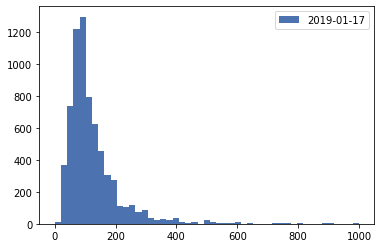

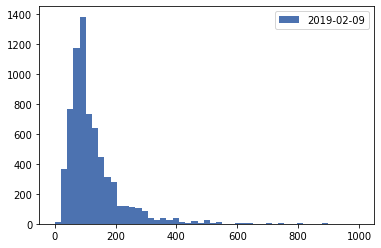

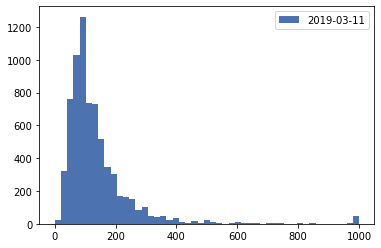

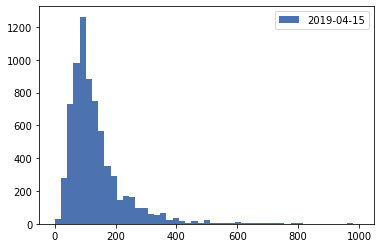

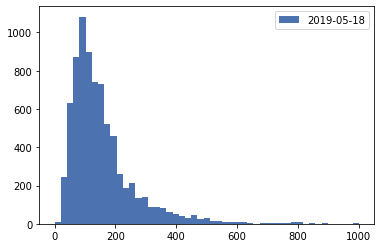

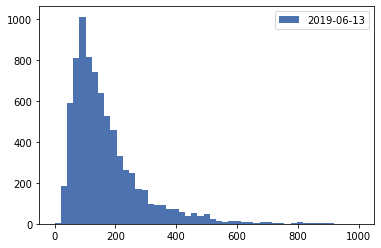

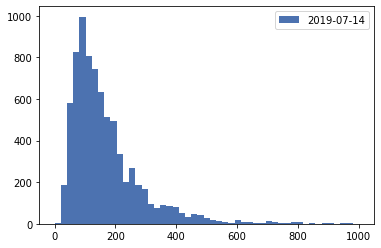

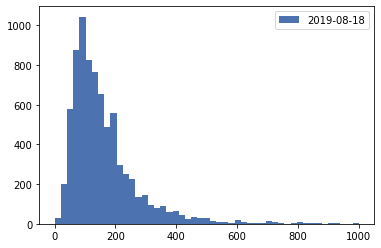

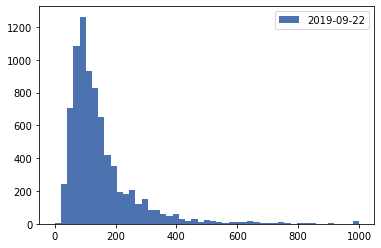

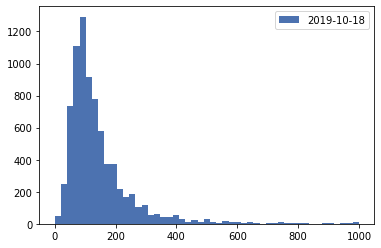

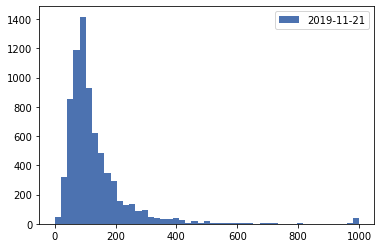

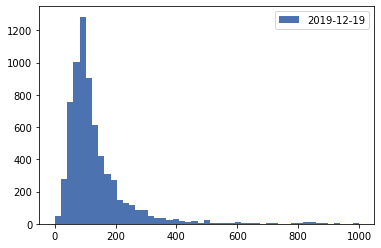

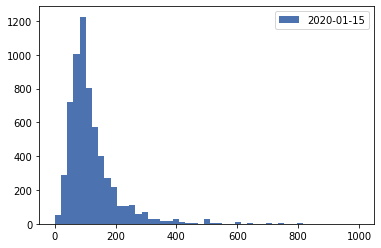

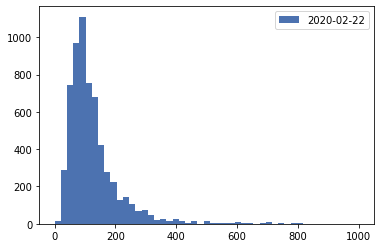

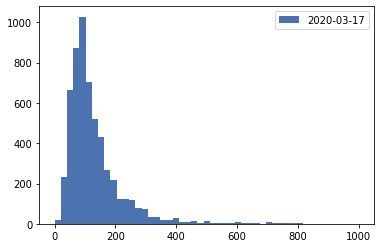

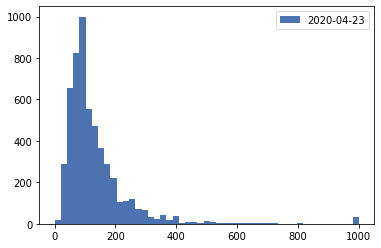

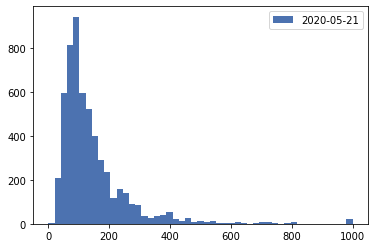

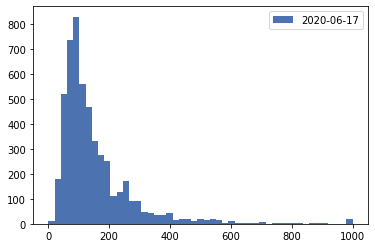

,no,mean_availability,mean_price,mean_cal_adjusted_price
2019-01-17,6847.0,0.390375,161.072587,124.635264
2019-02-09,6950.0,0.386062,160.677554,126.147017
2019-03-11,7081.0,0.297491,163.080356,138.384276
2019-04-15,7183.0,0.331008,167.871502,135.916807
2019-05-18,7797.0,0.247014,167.699628,156.204660
2019-06-13,7778.0,0.220554,170.482258,169.396916
2019-07-14,7747.0,0.205959,168.550536,168.743389
2019-08-18,7755.0,0.257541,166.089877,161.152520
2019-09-22,7934.0,0.334052,171.507688,149.528453
2019-10-18,7758.0,0.358958,173.286672,144.399992


In [5]:

# Let's have a look at all listings
analysis = analyze_listings(listings, plothist=True)
analysis


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

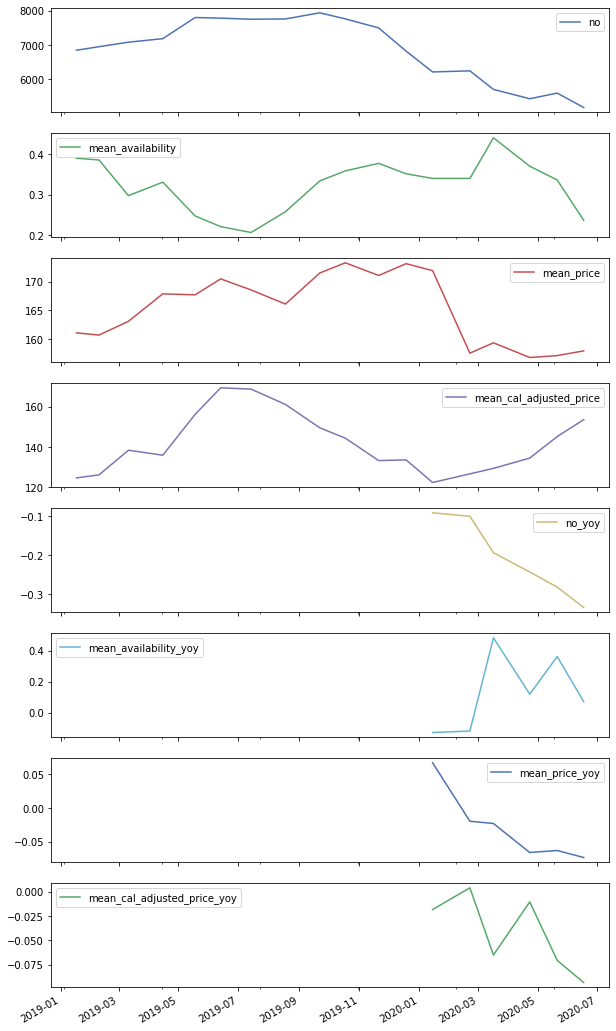

In [6]:
def fill_yoy(df, d1, d2):
    '''
    INPUT
    df - dataframe with airbnb listings data
    d1 - date of first year
    d2 - date of second year

    Add year-over-year comparison for the columns no, mean_availablity, mean_price and mean_cal_adjusted_price
    '''
    
    df.at[pd.to_datetime(d2), 'no_yoy'] = (analysis.loc[pd.to_datetime(d2), 'no'] - analysis.loc[pd.to_datetime(d1), 'no']) / analysis.loc[pd.to_datetime(d1), 'no']
    df.at[pd.to_datetime(d2), 'mean_availability_yoy'] = (analysis.loc[pd.to_datetime(d2), 'mean_availability'] - analysis.loc[pd.to_datetime(d1), 'mean_availability']) / analysis.loc[pd.to_datetime(d1), 'mean_availability']
    df.at[pd.to_datetime(d2), 'mean_price_yoy'] = (analysis.loc[pd.to_datetime(d2), 'mean_price'] - analysis.loc[pd.to_datetime(d1), 'mean_price']) / analysis.loc[pd.to_datetime(d1), 'mean_price']
    df.at[pd.to_datetime(d2), 'mean_cal_adjusted_price_yoy'] = (analysis.loc[pd.to_datetime(d2), 'mean_cal_adjusted_price'] - analysis.loc[pd.to_datetime(d1), 'mean_cal_adjusted_price']) / analysis.loc[pd.to_datetime(d1), 'mean_cal_adjusted_price']

fill_yoy(analysis, pd.to_datetime('20190117'), pd.to_datetime('20200115'))
fill_yoy(analysis, pd.to_datetime('20190209'), pd.to_datetime('20200222'))
fill_yoy(analysis, pd.to_datetime('20190311'), pd.to_datetime('20200317'))
fill_yoy(analysis, pd.to_datetime('20190415'), pd.to_datetime('20200423'))
fill_yoy(analysis, pd.to_datetime('20190518'), pd.to_datetime('20200521'))
fill_yoy(analysis, pd.to_datetime('20190613'), pd.to_datetime('20200617'))

analysis.plot(subplots=True, figsize=[10, 20])


In [7]:
print("Comparison June 2019 / June 2020")
print("Drop in listings: {}".format(analysis.loc[pd.to_datetime('20200617'), 'no_yoy']))
print("Drop in official pricing: {}".format(analysis.loc[pd.to_datetime('20200617'), 'mean_price_yoy']))
print("Drop in adjusted pricing: {}".format(analysis.loc[pd.to_datetime('20200617'), 'mean_cal_adjusted_price_yoy']))
print("Increase in availability: {} (=drop in utilization)".format(analysis.loc[pd.to_datetime('20200617'), 'mean_availability_yoy']))

Comparison June 2019 / June 2020
Drop in listings: -0.3333761892517357
Drop in official pricing: -0.07366419893247202
Drop in adjusted pricing: -0.0933731303813586
Increase in availability: 0.07050640374239554 (=drop in utilization)


# Who is offering a COVID-19 deep cleaning?

In [8]:
# Let's have a deeper look at the listings which offer a COVID-19 deep cleaning

listings['covid19_cleaning'] = listings.description.str.match('.*(covid|corona|cdc).*', case=False, na=False).astype(int)
clean_listings = listings[listings['covid19_cleaning']==1]
#clean_listings_june2020 = listings[(listings['covid19_cleaning']==1) & (listings['date'] == pd.to_datetime('20200617'))]
#clean_listings = listings[listings['id'].isin(clean_listings_june2020['id'])]

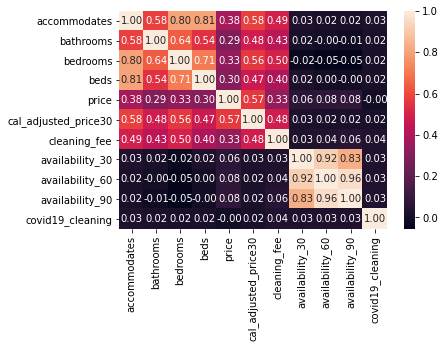

In [9]:
# Let's look at possible correlation between covid19_cleaning and other variables

# Problem: The variable covid19_cleaning is a boolean (represented as 0 and 1) and this kind of variable does not work well with the default pearson correlation from DataFrame.corr().
cols = ['accommodates','bathrooms','bedrooms','beds',
        'price', 'cal_adjusted_price30', 'cleaning_fee', 'availability_30', 'availability_60', 'availability_90', 'covid19_cleaning']
corr_pearson = listings[cols].corr()
sns.heatmap(corr_pearson, yticklabels = cols, xticklabels = cols, annot=True, fmt=".2f");


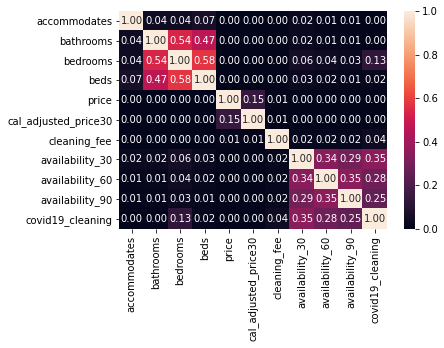

In [10]:

# A better approach to correlate covid19_cleaning with other variables is the hamming pairwise distance
# see: https://stackoverflow.com/questions/37003272/how-to-compute-jaccard-similarity-from-a-pandas-dataframe
distance_hamming = pd.DataFrame(1 - pairwise_distances(listings[cols].T, metric = "hamming"), index=cols, columns=cols)
sns.heatmap(distance_hamming, yticklabels = cols, xticklabels = cols, annot=True, fmt=".2f");


In [34]:
print("Hamming distance between covid19_cleaning and availability_30: {:.2f}".format(distance_hamming.loc['covid19_cleaning', 'availability_30']))
print("Hamming distance between covid19_cleaning and bedrooms: {:.2f}".format(distance_hamming.loc['covid19_cleaning', 'bedrooms']))
print("Hamming distance between covid19_cleaning and cal_adjusted_price30: {:.2f}".format(distance_hamming.loc['covid19_cleaning', 'cal_adjusted_price30']))


Hamming distance between covid19_cleaning and availability_30: 0.35
Hamming distance between covid19_cleaning and bedrooms: 0.13
Hamming distance between covid19_cleaning and cal_adjusted_price30: 0.00


In [ ]:
Found a significant correlation between COVID-19 deep cleaning and availability for the next 30, 60 and 90 days. An additional low correlation regarding the number of bedrooms is shown, but no correlation with price!

A COVID-19 deep cleaning seems to be offered in bigger listings with lower utilization.

# Is a COVID-19 deep cleaning offering helpful for landlords to get a better utilization?

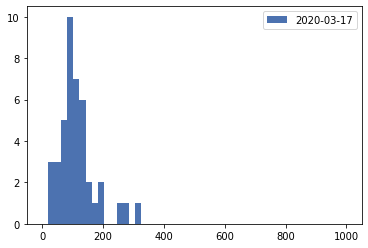

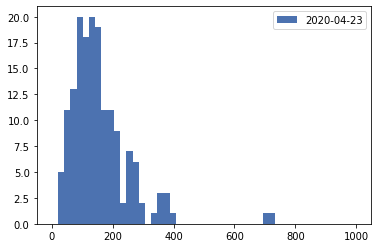

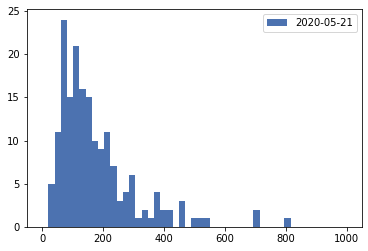

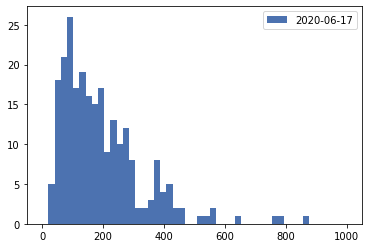

,no,mean_availability,mean_price,mean_cal_adjusted_price
2020-03-17,42.0,0.612698,145.476190,114.770874
2020-04-23,164.0,0.520325,156.195122,157.771878
2020-05-21,178.0,0.518539,171.410112,175.725870
2020-06-17,242.0,0.409091,160.524793,194.275888


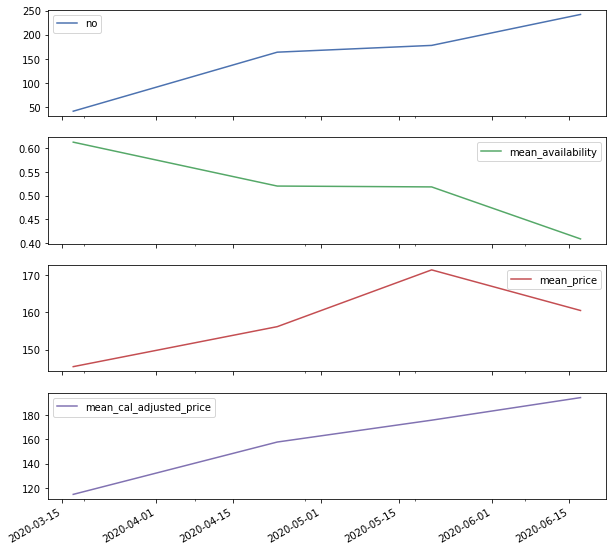

In [12]:

analysis_covid = analyze_listings(clean_listings, dates_filter = [pd.to_datetime('20200317'), pd.to_datetime('20200423'), pd.to_datetime('20200521'), pd.to_datetime('20200617')], plothist=True)
analysis_covid.plot(subplots=True, figsize=[10, 10])
analysis_covid


In [33]:
print("COVID-19 deep cleaning (March 2020)")
print("Listings without COVID-19 deep cleaning: {:n}".format(analysis.loc[pd.to_datetime('20200317'), 'no']))
print("Listings with COVID-19 deep cleaning: {:n}".format(analysis_covid.loc[pd.to_datetime('20200317'), 'no']))
print("Mean availability without COVID-19 deep cleaning: {:n}".format(analysis.loc[pd.to_datetime('20200317'), 'mean_availability']))
print("Mean availability with COVID-19 deep cleaning: {:n}".format(analysis_covid.loc[pd.to_datetime('20200317'), 'mean_availability']))
print("")
print("COVID-19 deep cleaning (June 2020)")
print("Listings without COVID-19 deep cleaning: {:n}".format(analysis.loc[pd.to_datetime('20200617'), 'no']))
print("Listings with COVID-19 deep cleaning: {:n}".format(analysis_covid.loc[pd.to_datetime('20200617'), 'no']))
print("Mean availability without COVID-19 deep cleaning: {:n}".format(analysis.loc[pd.to_datetime('20200617'), 'mean_availability']))
print("Mean availability with COVID-19 deep cleaning: {:n}".format(analysis_covid.loc[pd.to_datetime('20200617'), 'mean_availability']))
print("----------")
print("Change in mean availability without COVID-19 deep cleaning: {:n}".format(analysis.loc[pd.to_datetime('20200617'), 'mean_availability'] - analysis.loc[pd.to_datetime('20200317'), 'mean_availability']))
print("Change in mean availability with COVID-19 deep cleaning: {:n}".format(analysis_covid.loc[pd.to_datetime('20200617'), 'mean_availability'] - analysis_covid.loc[pd.to_datetime('20200317'), 'mean_availability']))



COVID-19 deep cleaning (March 2020)
Listings without COVID-19 deep cleaning: 5710
Listings with COVID-19 deep cleaning: 42
Mean availability without COVID-19 deep cleaning: 0.441121
Mean availability with COVID-19 deep cleaning: 0.612698

COVID-19 deep cleaning (June 2020)
Listings without COVID-19 deep cleaning: 5185
Listings with COVID-19 deep cleaning: 242
Mean availability without COVID-19 deep cleaning: 0.236104
Mean availability with COVID-19 deep cleaning: 0.409091
----------
Change in mean availability without COVID-19 deep cleaning: -0.205017
Change in mean availability with COVID-19 deep cleaning: -0.203608


Almost no difference in change of utilization between listings which offer COVID-19 deep cleaning and not.

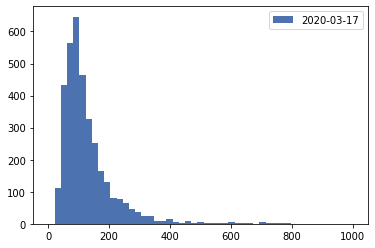

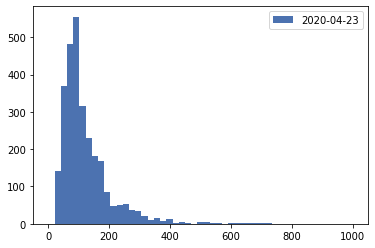

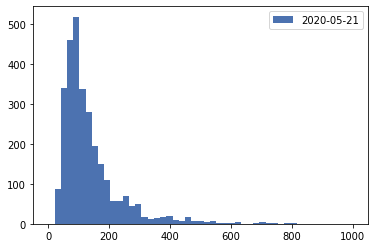

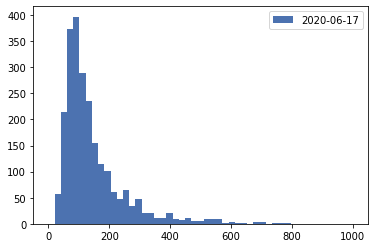

,no,mean_availability,mean_price,mean_cal_adjusted_price
2020-03-17,3532.0,0.699387,168.580974,126.557491
2020-04-23,2857.0,0.682464,156.089954,122.472486
2020-05-21,2921.0,0.630343,156.179048,136.490220
2020-06-17,2364.0,0.504089,157.216582,145.313111


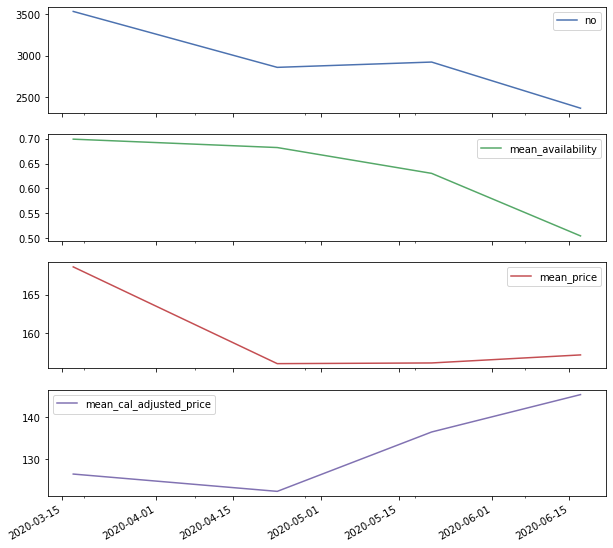

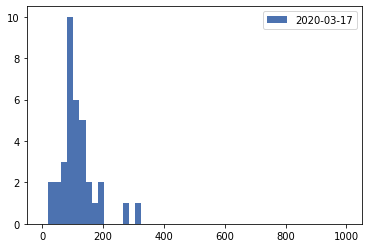

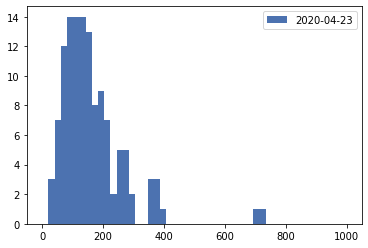

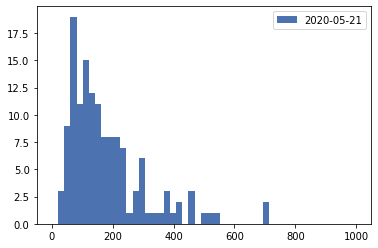

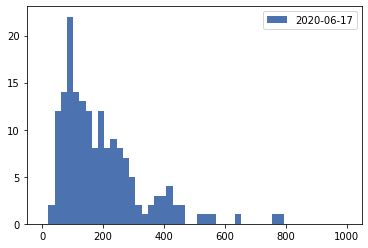

,no,mean_availability,mean_price,mean_cal_adjusted_price
2020-03-17,35.0,0.735238,155.942857,117.392587
2020-04-23,124.0,0.678763,162.854839,164.201428
2020-05-21,138.0,0.647826,178.586957,179.057607
2020-06-17,171.0,0.566862,164.210526,193.490768


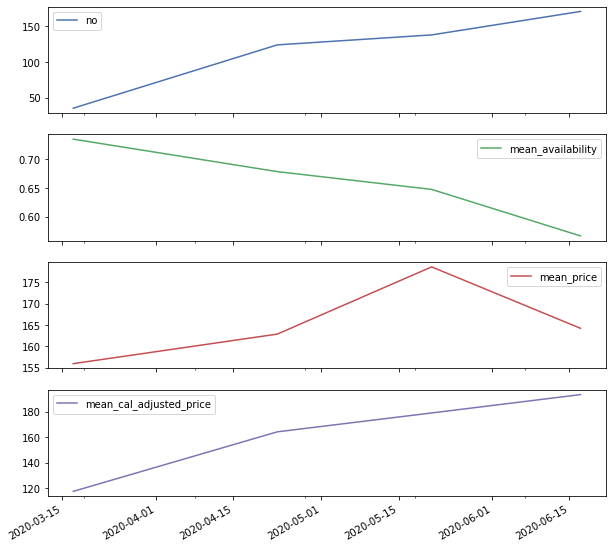

In [14]:
listings_200 = listings[(listings.cal_adjusted_price30 < 800 ) & (listings.cal_adjusted_price30 > 30) & (listings.availability_30 > 0.10)]
clean_listings_200 = listings_200[listings_200['covid19_cleaning']==1]

analysis_200 = analyze_listings(listings_200, dates_filter = [pd.to_datetime('20200317'), pd.to_datetime('20200423'), pd.to_datetime('20200521'), pd.to_datetime('20200617')], plothist=True)
analysis_200.plot(subplots=True, figsize=[10, 10])
display(analysis_200)
plt.show()

# No idea what's going on here, but the last (!) plot (no matter how many there are in the code) is always messed up. Ignore this one and be fine with the first!
# This happens only here with analysis_200, nowhere else. Might be related to this issue in pandas: https://github.com/pandas-dev/pandas/issues/10761
#analysis_200.plot(subplots=True, figsize=[10, 10]) 

analysis_covid_200 = analyze_listings(clean_listings_200, dates_filter = [pd.to_datetime('20200317'), pd.to_datetime('20200423'), pd.to_datetime('20200521'), pd.to_datetime('20200617')], plothist=True)
display(analysis_covid_200)
analysis_covid_200.plot(subplots=True, figsize=[10, 10])
plt.show()



In [15]:
print(listings.columns.values)

['id' 'listing_url' 'scrape_id' 'last_scraped' 'name' 'summary' 'space'
 'description' 'experiences_offered' 'neighborhood_overview' 'notes'
 'transit' 'access' 'interaction' 'house_rules' 'thumbnail_url'
 'medium_url' 'picture_url' 'xl_picture_url' 'host_id' 'host_url'
 'host_name' 'host_since' 'host_location' 'host_about'
 'host_response_time' 'host_response_rate' 'host_acceptance_rate'
 'host_is_superhost' 'host_thumbnail_url' 'host_picture_url'
 'host_neighbourhood' 'host_listings_count' 'host_total_listings_count'
 'host_verifications' 'host_has_profile_pic' 'host_identity_verified'
 'street' 'neighbourhood' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'zipcode' 'market'
 'smart_location' 'country_code' 'country' 'latitude' 'longitude'
 'is_location_exact' 'property_type' 'room_type' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'amenities' 'square_feet'
 'price' 'weekly_price' 'monthly_price' 'security_deposit' 'cleaning_fee'
 'guests_include

In [18]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    display(cat_cols)
    df_copy = pd.get_dummies(df[cat_cols], prefix = cat_cols, dummy_na = dummy_na, drop_first = True)
    df_copy = df_copy.join(df[df.columns.difference(cat_cols)])
    
    return df_copy

['id' 'listing_url' 'scrape_id' 'last_scraped' 'name' 'summary' 'space'
 'description' 'experiences_offered' 'neighborhood_overview' 'notes'
 'transit' 'access' 'interaction' 'house_rules' 'thumbnail_url'
 'medium_url' 'picture_url' 'xl_picture_url' 'host_id' 'host_url'
 'host_name' 'host_since' 'host_location' 'host_about'
 'host_response_time' 'host_response_rate' 'host_acceptance_rate'
 'host_is_superhost' 'host_thumbnail_url' 'host_picture_url'
 'host_neighbourhood' 'host_listings_count' 'host_total_listings_count'
 'host_verifications' 'host_has_profile_pic' 'host_identity_verified'
 'street' 'neighbourhood' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'zipcode' 'market'
 'smart_location' 'country_code' 'country' 'latitude' 'longitude'
 'is_location_exact' 'property_type' 'room_type' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'amenities' 'square_feet'
 'price' 'weekly_price' 'monthly_price' 'security_deposit' 'cleaning_fee'
 'guests_include

,ngc_Beacon Hill,ngc_Capitol Hill,ngc_Cascade,ngc_Central Area,ngc_Delridge,ngc_Downtown,ngc_Interbay,ngc_Lake City,ngc_Magnolia,ngc_Northgate,ngc_Other neighborhoods,ngc_Queen Anne,ngc_Rainier Valley,ngc_Seward Park,ngc_University District,ngc_West Seattle,covid19_cleaning
ngc_Beacon Hill,1.000000,0.856187,0.913994,0.870691,0.931064,0.786368,0.957183,0.945172,0.941367,0.939870,0.777125,0.889412,0.910554,0.951639,0.934245,0.904418,0.956390
ngc_Capitol Hill,0.856187,1.000000,0.848109,0.804806,0.865179,0.720483,0.891298,0.879287,0.875483,0.873985,0.711240,0.823528,0.844669,0.885754,0.868360,0.838534,0.890829
ngc_Cascade,0.913994,0.848109,1.000000,0.862613,0.922986,0.778290,0.949105,0.937094,0.933290,0.931792,0.769047,0.881335,0.902476,0.943561,0.926167,0.896341,0.948425
ngc_Central Area,0.870691,0.804806,0.862613,1.000000,0.879683,0.734988,0.905803,0.893791,0.889987,0.888490,0.725744,0.838032,0.859173,0.900258,0.882864,0.853038,0.905074
ngc_Delridge,0.931064,0.865179,0.922986,0.879683,1.000000,0.795361,0.966175,0.954164,0.950360,0.948862,0.786117,0.898405,0.919546,0.960631,0.943237,0.913411,0.965139
ngc_Downtown,0.786368,0.720483,0.778290,0.734988,0.795361,1.000000,0.821480,0.809468,0.805664,0.804167,0.641422,0.753709,0.774850,0.815935,0.798541,0.768715,0.822451
ngc_Interbay,0.957183,0.891298,0.949105,0.905803,0.966175,0.821480,1.000000,0.980283,0.976479,0.974982,0.812236,0.924524,0.945665,0.986750,0.969356,0.939530,0.991080
ngc_Lake City,0.945172,0.879287,0.937094,0.893791,0.954164,0.809468,0.980283,1.000000,0.964468,0.962970,0.800225,0.912512,0.933654,0.974739,0.957345,0.927519,0.979279
ngc_Magnolia,0.941367,0.875483,0.933290,0.889987,0.950360,0.805664,0.976479,0.964468,1.000000,0.959166,0.796421,0.908708,0.929850,0.970935,0.953541,0.923714,0.975589
ngc_Northgate,0.939870,0.873985,0.931792,0.888490,0.948862,0.804167,0.974982,0.962970,0.959166,1.000000,0.794923,0.907211,0.928352,0.969437,0.952043,0.922217,0.973913


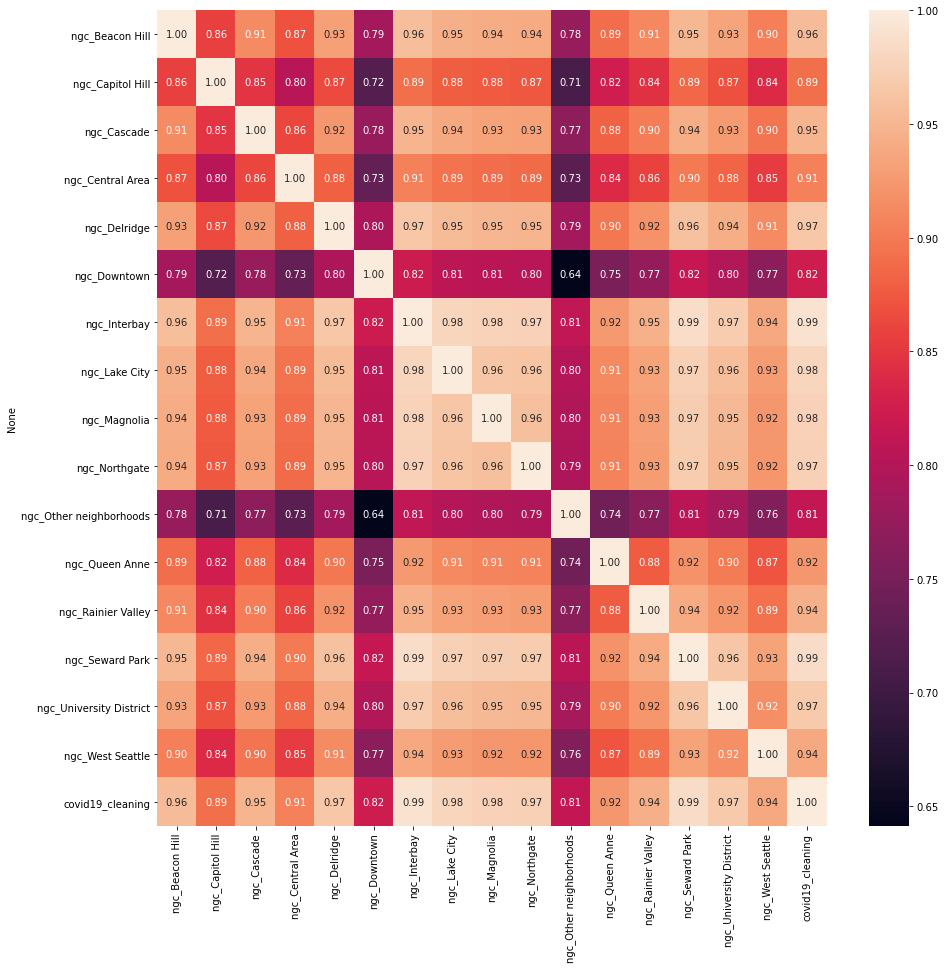

In [26]:

#listings['neighbourhood_group_cleansed']

#pd.get_dummies(listings[['neighbourhood_group_cleansed']], prefix = 'neighbourhood_group_cleansed')

#listings_neighbourhood = create_dummy_df(listings, ['neighbourhood_group_cleansed'], dummy_na=False)
listings_neighbourhood = listings.join(pd.get_dummies(listings[['neighbourhood_group_cleansed']], prefix = 'ngc'))
#display(listings_neighbourhood)
cols_neighbourhood_cleaning = ['ngc_Beacon Hill',
 'ngc_Capitol Hill',
 'ngc_Cascade',
 'ngc_Central Area',
 'ngc_Delridge',
 'ngc_Downtown',
 'ngc_Interbay',
 'ngc_Lake City',
 'ngc_Magnolia',
 'ngc_Northgate',
 'ngc_Other neighborhoods',
 'ngc_Queen Anne',
 'ngc_Rainier Valley',
 'ngc_Seward Park',
 'ngc_University District',
 'ngc_West Seattle',
 'covid19_cleaning']
#cols = ['accommodates','bathrooms','bedrooms','beds',
#        'price', 'cal_adjusted_price30', 'cleaning_fee', 'availability_30', 'availability_60', 'availability_90', 'covid19_cleaning']

print(listings_neighbourhood.columns.values)
distance_hamming_neighbourhood_cleaning = pd.DataFrame(1 - pairwise_distances(listings_neighbourhood[cols_neighbourhood_cleaning].T, metric = "hamming"), index=[cols_neighbourhood_cleaning], columns=cols_neighbourhood_cleaning)
plt.figure(figsize = (15,15))
sns.heatmap(distance_hamming_neighbourhood_cleaning, yticklabels = cols_neighbourhood_cleaning, xticklabels = cols_neighbourhood_cleaning, annot=True, fmt=".2f");
distance_hamming_neighbourhood_cleaning
